In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request
import csv
from bs4 import BeautifulSoup
import locale
from datetime import datetime
import pandas as pd
from sklearn.utils import shuffle
from pandas_datareader import data as web
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re
import string
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunkunxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yunkunxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yunkunxu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def GetStockPrice(stock, startDate, endDate, method):
    if method == 0:
        Stockdf = web.DataReader(stock, 'yahoo', startDate, endDate)
        SPX = web.DataReader('^GSPC', 'yahoo', startDate, endDate)
        AdjClosedf = pd.DataFrame(Stockdf['Adj Close'].pct_change() - SPX['Adj Close'].pct_change())
        AdjClosedf.loc[:,'Label'] = (AdjClosedf['Adj Close']>0.003).astype(int) - (AdjClosedf['Adj Close']< -0.003).astype(int)

    else:
        page = urllib.request.urlopen('https://finance.yahoo.com/quote/'+stock+'/history?period1=1474095600&period2=1504249200&interval=1d&filter=history&frequency=1d').read()
        soup = BeautifulSoup(page, 'html5lib')
        snap = soup.find("table", class_="W(100%) M(0)")
        snap_body = snap.find('tbody')
        rows = snap_body.find_all('tr')

        #print "Number of data: %d\n" % (len(rows))
        Datelist = []
        AdjCloselist = []

        for element in rows:
            s = element.find_all("span")
            if len(s) == 7:
                Datelist.append(datetime.strptime(s[0].get_text(), '%b %d, %Y'))
                AdjCloselist.append(locale.atof(s[5].get_text().replace(',','')))

        AdjClosedf = pd.DataFrame(AdjCloselist,columns=[stock],index = Datelist)
        #print(AdjClosedf.columns)
        AdjClosedf = AdjClosedf.sort_index()
        AdjClosedf.rename(columns={stock: 'Adj Close'}, inplace=True)
        AdjClosedf.loc[:,'Label'] = (AdjClosedf['Adj Close'].pct_change()>0).astype(int)
        
    return AdjClosedf

In [3]:
def GetStockNews(stock, TopN, DateRange):
    data = {}
    for ndate in tqdm(DateRange):
        data[ndate] = []
        #print ndate.strftime('%Y-%m-%d')
        startdate = ndate.strftime('%Y-%m-%d')
        enddate = startdate
        page = urllib.request.urlopen('https://finance.google.com/finance/company_news?q=NASDAQ%3A'+stock+
                                      '&startdate='+startdate+'&enddate='+enddate).read()
        soup= BeautifulSoup(page, 'html5lib')
        news = soup.find_all("div", class_="g-section news sfe-break-bottom-16")
        #print ("Number of news: %d\n" % (len(news)))
        data[ndate].append(stock)
        for element in news[:TopN]:
            t = element.find_all("span", class_="name")[0].get_text().replace('\xa0',' ').replace('\n','')#.encode('utf-8')
            #print t 
            data[ndate].append(t)
        for i in range(0,TopN - len(news),1):
            data[ndate].append('')
    df = pd.DataFrame().from_dict(data).T
    return df

In [5]:
stock = 'GOOG'
start = '2015-01-01'
end = '2017-09-30'
TopN = 10
AdjClosedf = GetStockPrice(stock,start,end,method=0)
DateRange = AdjClosedf.index
newsdf = GetStockNews(stock, TopN, DateRange)
datadf = pd.concat([AdjClosedf.loc[:,'Label'],newsdf],axis = 1)
datadf.to_csv(stock+'.csv',encoding= 'utf-8')

100%|██████████| 692/692 [07:05<00:00,  1.22s/it]


### Data Processing

In [4]:
def FilterSentence(headline):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    headline = headline.lower().encode('utf-8').decode('ascii','ignore')
    sentence = tknzr.tokenize(headline)
    sent = nltk.pos_tag(sentence)
    tempfiltered_words = [s[0] for s in sent if s[1][0] in ['J','V','N']]
    stops = set(stopwords.words("english"))
    exclude = set(string.punctuation+'‘’“”0123456789')
    filtered_words = ' '.join(word.lower() for word in tempfiltered_words if (word not in stops) and (word not in exclude))
    filtered_words = re.sub(r'[^\w\s]', '', filtered_words)
    filtered_words = re.sub(r'\d+', '', filtered_words)
    filtered_words = re.sub(r'(.)\1{2,}', r'\1'*2, filtered_words)
    return filtered_words

In [26]:
datadf = pd.read_csv('GOOG.csv')
datadf.index = datadf['Date']
datadf = datadf.drop(['Date'],axis=1)
datadf.iloc[:,1:] = datadf.iloc[:,1:].astype(str)
dataset = pd.DataFrame()
dataset['Headlines'] = datadf.iloc[:-1,2]+' '+ datadf.iloc[:-1,3]+' '+ datadf.iloc[:-1,4]+' '+ datadf.iloc[:-1,5]+' '+ datadf.iloc[:-1,6]+' '+ datadf.iloc[:-1,7]+' '+ datadf.iloc[:-1,8]+' '+ datadf.iloc[:-1,9]+' '+ datadf.iloc[:-1,10]+' '+ datadf.iloc[:-1,11]
dataset.index = datadf.index[1:]
dataset['Label'] = datadf['Label'].iloc[1:]
dataset.head()

,Headlines,Label
Date,,
2015-01-05,Microsoft Corporation Is About to Abandon Inte...,0
2015-01-06,Learning Matters: Failure Can Lead to Success ...,-1
2015-01-07,Why It's Time For Google To Pay A Dividend 1 T...,-1
2015-01-08,Myth-Busting Netflix Inc.'s Rumored VPN Crackd...,-1
2015-01-09,Google Inc's Smart Home Strategy Taking Shape ...,-1


In [27]:
print('Number of stock prices collected:', len(dataset))
print('Number of missing news:', dataset.isnull().values.sum())
data = dataset.dropna(axis=0, how='any')
print('Number of missing news after cleaning:', data.isnull().values.sum())
print('Number of news collected:', len(data))

Number of stock prices collected: 691
Number of missing news: 0
Number of missing news after cleaning: 0
Number of news collected: 691


In [28]:
data['Headlines'] = data['Headlines'].apply(FilterSentence)
data.head()

,Headlines,Label
Date,,
2015-01-05,microsoft corporation abandon internet explore...,0
2015-01-06,learning matters failure lead success wear vir...,-1
2015-01-07,its time google pay dividend trend worry inc i...,-1
2015-01-08,mythbusting netflix inc rumored vpn crackdown ...,-1
2015-01-09,google incs smart home strategy taking shape s...,-1


In [29]:
word_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
sparse_matrix = word_vectorizer.fit_transform(data['Headlines'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print(words.describe())
words.head()

         frequency
count  9219.000000
mean      4.409047
std      20.497423
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max    1084.000000


,frequency
aa,5
aac,1
aadhar,1
aapl,147
aaplus,1


In [30]:
word_vectorizer = CountVectorizer(analyzer='word', stop_words='english',min_df=2, max_df=3000)
sparse_matrix = word_vectorizer.fit_transform(data['Headlines'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print(words.describe())
words.head()


         frequency
count  3962.000000
mean      8.924785
std      30.691671
min       2.000000
25%       2.000000
50%       3.000000
75%       7.000000
max    1084.000000


,frequency
aa,5
aapl,147
abandons,2
abat,2
abbvie,2


In [31]:
del words

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 250
n_components = 20
n_top_words = 10

### Counts
tf_vectorizer = CountVectorizer(min_df=2, max_df=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(data['Headlines'])
tf_feature_names = tf_vectorizer.get_feature_names()
print(tf_feature_names)

['aa', 'aapl', 'abandons', 'abat', 'abbvie', 'abc', 'abcs', 'accelerate', 'accelerated', 'accelerates', 'accepts', 'access', 'accident', 'according', 'accounting', 'accounts', 'accusations', 'accused', 'accuses', 'acquire', 'acquired', 'acquires', 'acquiring', 'acquisition', 'acquisitions', 'act', 'action', 'active', 'activision', 'activist', 'activists', 'activity', 'actual', 'ad', 'adam', 'adblocking', 'add', 'adding', 'additions', 'addresses', 'adds', 'administration', 'admits', 'adobe', 'adoption', 'adr', 'adrian', 'ads', 'adsense', 'advance', 'advanced', 'advances', 'advantage', 'advantages', 'adventure', 'advertiser', 'advertisers', 'advertising', 'advice', 'adviser', 'advisers', 'advisor', 'advisory', 'advocating', 'adwords', 'affect', 'afraid', 'africa', 'ag', 'age', 'agency', 'agreement', 'agrees', 'agthx', 'ai', 'aid', 'aim', 'aims', 'aipowered', 'air', 'airbnb', 'airbus', 'aircraft', 'airg', 'airgain', 'airport', 'akam', 'akamai', 'alert', 'alexa', 'algorithm', 'alibaba', 'a

In [33]:
## TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=2,max_df=1000,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['Headlines'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print(tfidf_feature_names)

['aa', 'aapl', 'abandons', 'abat', 'abbvie', 'abc', 'abcs', 'accelerate', 'accelerated', 'accelerates', 'accepts', 'access', 'accident', 'according', 'accounting', 'accounts', 'accusations', 'accused', 'accuses', 'acquire', 'acquired', 'acquires', 'acquiring', 'acquisition', 'acquisitions', 'act', 'action', 'active', 'activision', 'activist', 'activists', 'activity', 'actual', 'ad', 'adam', 'adblocking', 'add', 'adding', 'additions', 'addresses', 'adds', 'administration', 'admits', 'adobe', 'adoption', 'adr', 'adrian', 'ads', 'adsense', 'advance', 'advanced', 'advances', 'advantage', 'advantages', 'adventure', 'advertiser', 'advertisers', 'advertising', 'advice', 'adviser', 'advisers', 'advisor', 'advisory', 'advocating', 'adwords', 'affect', 'afraid', 'africa', 'ag', 'age', 'agency', 'agreement', 'agrees', 'agthx', 'ai', 'aid', 'aim', 'aims', 'aipowered', 'air', 'airbnb', 'airbus', 'aircraft', 'airg', 'airgain', 'airport', 'akam', 'akamai', 'alert', 'alexa', 'algorithm', 'alibaba', 'a

### Finding topics with LDA

In [34]:
lda = LatentDirichletAllocation(n_components, learning_method='online', random_state=1)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [35]:
print("\nTopics in LDA model:")
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: company atvi blizzard activision industry inside house download cell ios
Topic #1: google stock mobile nyc best look apple law service uber
Topic #2: watch great ceo twitter dorsey change help jack apple wants
Topic #3: path ebay improvement york companies boast backs nasa power acquired
Topic #4: leaps understand days inside otcmkts google infinity examining enters millennial
Topic #5: otcmkts google stock apple happened market facebook new corp news
Topic #6: korean used dropped multinationals sling looking smart japanese finds kids
Topic #7: lynch merrill uses black ebay jeff motorolas endangered moto nation
Topic #8: google stock apple tech facebook buy stocks new big amazon
Topic #9: researchers ipo things boss mind shopify know office maker software
Topic #10: sex protecting marks hulk australia unicorns viewing sidewalk tape english
Topic #11: game online taylor play street nysearca proshares ag taxi ditches
Topic #12: enterprise help investors sm

In [36]:
lda = LatentDirichletAllocation(n_components, learning_method='online', random_state=1)
lda.fit(tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [37]:
print("\nTopics in LDA model:")
print_top_words(lda, tfidf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: computing nan good ii hearing music position raises new general
Topic #1: biopharma sbfm sunshine google stock alphabet apple new googl tech
Topic #2: poster child hiv carey google conversation loan mariah app better
Topic #3: technology google monthly company learns swift taylor hbo women internet
Topic #4: community nan partnerships facebook ces hints la webtv earn supplier
Topic #5: grog pao ellen grogenesis sister brown governor dies godaddy xs
Topic #6: nan google dont products googles mobile new talk alphabet dating
Topic #7: nan answers hope page effective strategist quiz ruth electric institute
Topic #8: season otcmkts teaches new epic googles alphabet ipo project person
Topic #9: otcmkts holdings future zuckerberg america cutting nan looking look world
Topic #10: apple google facebook ads intelligence company investors rocket help allo
Topic #11: nan ocean paradise spread floating pope dilemma cells couple trash
Topic #12: google small compete a

### Sentiment Analysis

In [38]:
positive = pd.read_csv('positive-words.txt', names=['a'], encoding='latin-1')
positive =  set(positive['a'].tolist())

negative = pd.read_csv('negative-words.txt', names=['a'], encoding='latin-1')
negative =  set(negative['a'].tolist())

In [39]:
count_positive = []
count_negative = []
for i, row in data.iterrows():
    commonp = set(row['Headlines'].split()).intersection(positive) 
    count_positive.append(len(commonp))
    commonn = set(row['Headlines'].split()).intersection(negative) 
    count_negative.append(len(commonn))


In [40]:
data['positive'] = count_positive
data['negative'] = count_negative

data.head()

,Headlines,Label,positive,negative
Date,,,,
2015-01-05,microsoft corporation abandon internet explore...,0,4,1
2015-01-06,learning matters failure lead success wear vir...,-1,3,2
2015-01-07,its time google pay dividend trend worry inc i...,-1,0,2
2015-01-08,mythbusting netflix inc rumored vpn crackdown ...,-1,1,2
2015-01-09,google incs smart home strategy taking shape s...,-1,3,1


In [41]:
data.describe()

,Label,positive,negative
count,691.000000,691.000000,691.000000
mean,0.046310,2.674385,2.344428
std,0.816956,1.627542,1.622320
min,-1.000000,0.000000,0.000000
25%,-1.000000,1.000000,1.000000
50%,0.000000,3.000000,2.000000
75%,1.000000,4.000000,3.000000
max,1.000000,9.000000,9.000000


In [45]:
data_up = data.loc[data['Label'] == 1]
data_neu = data.loc[data['Label'] == 0]
data_down = data.loc[data['Label'] == -1]
print(len(data_up), len(data_neu),len(data_down))
print("Percentage of positve sentiments  : %s " % (len(data_up)* 100.0 / len(data)))
print("Percentage of neutral sentiments  : %s " % (len(data_neu)* 100.0 / len(data)))
print("Percentage of negative sentiments : %s " % (len(data_down)* 100.0 / len(data)))

247 229 215
Percentage of positve sentiments  : 35.74529667149059 
Percentage of neutral sentiments  : 33.140376266280754 
Percentage of negative sentiments : 31.114327062228654 


In [46]:
#data = data_up.append(data_down)
dataset_X = data.drop('Label',axis=1)
dataset_y = data['Label']
print(len(dataset_X), len(dataset_y))

691 691


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(dataset_X,dataset_y,test_size=0.2,stratify=dataset_y,random_state=1)

down = y_train[y_train == -1].count()
neu = y_train[y_train == 0].count()
up = y_train[y_train == 1].count()
print('Training dataset:')
print('Percentage of positive sentiments:', up*100/len(y_train))
print('Percentage of neutral sentiments:', neu*100/len(y_train))
print('Percentage of negative sentiments:', down*100/len(y_train))

down2 = y_test[y_test == -1].count()
neu2 = y_test[y_test == 0].count()
up2 = y_test[y_test == 1].count()
print('Training dataset:')
print('Percentage of positive sentiments:', up2*100/len(y_test))
print('Percentage of neutral sentiments:', neu2*100/len(y_test))
print('Percentage of negative sentiments:', down2*100/len(y_test))



Training dataset:
Percentage of positive sentiments: 35.6884057971
Percentage of neutral sentiments: 33.152173913
Percentage of negative sentiments: 31.1594202899
Training dataset:
Percentage of positive sentiments: 35.9712230216
Percentage of neutral sentiments: 33.0935251799
Percentage of negative sentiments: 30.9352517986


### Word2Vec

In [52]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [53]:
from gensim import matutils
matrix_train = []
for i in range(len(X_train)):
    row = X_train.iloc[i,:]
    filtered_text = [model[w] for w in row['Headlines'].split() if w in model]
    if len(filtered_text):
        matrix_train.append(matutils.unitvec(np.array(filtered_text).mean(axis=0)))


In [54]:
matrix_train = np.array(matrix_train)
print(matrix_train.shape)
sim_train = np.dot(matrix_train, matrix_train.transpose())
print(sim_train)

(552, 300)
[[ 1.          0.83516824  0.88879676 ...,  0.86300733  0.85127626
   0.82591915]
 [ 0.83516824  1.          0.84389732 ...,  0.84223025  0.84924325
   0.87568103]
 [ 0.88879676  0.84389732  1.         ...,  0.86671206  0.86672214
   0.816916  ]
 ..., 
 [ 0.86300733  0.84223025  0.86671206 ...,  1.          0.84415522
   0.84731102]
 [ 0.85127626  0.84924325  0.86672214 ...,  0.84415522  1.          0.83581096]
 [ 0.82591915  0.87568103  0.816916   ...,  0.84731102  0.83581096  1.        ]]


In [55]:
print(sim_train.shape)
np.fill_diagonal(sim_train, 0)
# simdf_train = pd.DataFrame(list(sim_train[np.triu_indices(sim_train.shape[1], 1)]))
# simdf_train.describe()

(552, 552)


In [56]:
overview_train = pd.concat([X_train,y_train],axis=1)
overview_train.head()

,Headlines,positive,negative,Label
Date,,,,
2016-01-14,companies alphabet inc facebook inc alphabet i...,2,1,1
2016-09-23,priceline expedia watch google google launches...,7,1,1
2017-05-15,go inc googl stock money better buy google goo...,4,2,0
2017-06-01,analysts expecting selfdriving cars huge alpha...,3,0,-1
2015-08-28,watch magician propose girlfriend magic trick ...,4,2,-1


In [57]:
#### Get the most similar tweets for each sentiment
up = 0
most_similar = np.argmax(sim_train[up][:])
print("similarity:", sim_train[up][most_similar])
print(X_train.iloc[up].Headlines)
print()
print(X_train.iloc[most_similar].Headlines)

similarity: 0.914967252485
companies alphabet inc facebook inc alphabet inc amazoncom inc stay hot cs stock target raised youtube red adoption google add partners selfdriving cars exec new degree camera save gopro inc apple underowned hedge fund land president obama talk selfdriving cars state union speech invest san francisco stocks strategist bets stock market poised vshaped rebound half p bear market

alphabet inc googl stock investors worry govt regulation amazoncom inc amzn vs alphabet inc googl best year bet sergey brin avoiding deposition waymo v uber data firm backed googles eric schmidt paid millions democratic committees google home competitive strengths fast growing smart speaker market google hopes train people africa online skills ceo tech shares fall weighing broader market apple alphabet tumble techs rattled dow transports plunge time sell fang stock take facebook inc fb stock add time presto money tech giants bobble backlash


In [58]:
#### Get the most similar tweets for each sentiment
down = 0
most_similar = np.argmax(sim_train[down][:])
print("similarity:", sim_train[down][most_similar])
print(X_train.iloc[down].Headlines)
print()
print(X_train.iloc[most_similar].Headlines)

similarity: 0.914967252485
companies alphabet inc facebook inc alphabet inc amazoncom inc stay hot cs stock target raised youtube red adoption google add partners selfdriving cars exec new degree camera save gopro inc apple underowned hedge fund land president obama talk selfdriving cars state union speech invest san francisco stocks strategist bets stock market poised vshaped rebound half p bear market

alphabet inc googl stock investors worry govt regulation amazoncom inc amzn vs alphabet inc googl best year bet sergey brin avoiding deposition waymo v uber data firm backed googles eric schmidt paid millions democratic committees google home competitive strengths fast growing smart speaker market google hopes train people africa online skills ceo tech shares fall weighing broader market apple alphabet tumble techs rattled dow transports plunge time sell fang stock take facebook inc fb stock add time presto money tech giants bobble backlash


#### Use PCA to reduce overfitting

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
pca.fit(matrix_train)
matrix_t_train = pca.transform(matrix_train)

print(pca.explained_variance_ratio_)

[  1.05614192e-01   6.97491635e-02   5.15152771e-02   3.26109251e-02
   3.15675669e-02   2.33806618e-02   2.01051260e-02   1.82414995e-02
   1.66109572e-02   1.56531374e-02   1.42792361e-02   1.31363525e-02
   1.26665099e-02   1.20703090e-02   1.15305977e-02   1.06946719e-02
   1.00775422e-02   9.96025914e-03   9.50601041e-03   9.06646409e-03
   8.68471461e-03   8.40321824e-03   8.25287816e-03   7.84146589e-03
   7.68013376e-03   7.38470168e-03   7.35175966e-03   7.29273714e-03
   7.05223400e-03   6.81605121e-03   6.71262535e-03   6.50956358e-03
   6.36348718e-03   6.20565599e-03   5.85121061e-03   5.75118435e-03
   5.60409880e-03   5.52291177e-03   5.41973794e-03   5.28974644e-03
   5.14342646e-03   5.11859266e-03   4.98671167e-03   4.89305729e-03
   4.85388339e-03   4.71082525e-03   4.69225465e-03   4.59490179e-03
   4.48208474e-03   4.43211862e-03   4.29659035e-03   4.25848590e-03
   4.23260573e-03   4.13558514e-03   4.08143514e-03   4.03997351e-03
   3.95764170e-03   3.89976201e-03

In [60]:
train1 = X_train.drop('Headlines',axis=1)
train1.index = range(len(train1))
train2 = pd.DataFrame(matrix_t_train)
# print test.index
# print test2.index
train3 = pd.concat([train1, train2], axis=1)
train3.head()

,positive,negative,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,2,1,0.230988,-0.015785,0.092101,-0.030682,-0.035586,-0.025882,-0.065892,0.020105,...,-0.000427,-0.000937,0.005433,-0.000585,0.000422,0.005140,-0.002121,0.001998,-0.002016,0.000838
1,7,1,-0.008066,0.125249,-0.130344,-0.062121,-0.033352,-0.024753,-0.007246,0.008037,...,-0.004141,-0.001309,-0.000389,-0.001882,-0.001758,0.002258,-0.003622,0.000029,0.000438,0.000956
2,4,2,0.244715,-0.025259,0.074581,-0.111683,-0.074492,-0.067843,0.024614,0.028476,...,-0.008544,-0.008453,0.000230,-0.002855,-0.002513,0.003853,0.005002,-0.002106,0.000088,-0.002012
3,3,0,0.228230,0.041941,0.007872,0.074918,-0.022412,-0.015557,-0.008418,0.082454,...,0.005429,-0.001525,0.002077,0.002798,-0.006099,0.008669,0.005765,-0.003023,0.008973,-0.003658
4,4,2,-0.180592,-0.072792,0.048416,0.077854,-0.007459,-0.056951,0.031569,-0.008083,...,0.002305,0.006086,0.002476,0.001553,0.005799,0.002683,0.003659,0.001959,-0.004440,0.005500


In [61]:
from sklearn import preprocessing

train3_scaled = pd.DataFrame(preprocessing.scale(train3),index=train3.index,columns=train3.columns)
train3_scaled.head()

,positive,negative,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,-0.409590,-0.854192,1.580129,-0.132878,0.902112,-0.377714,-0.445269,-0.376295,-1.033106,0.330925,...,-0.087606,-0.196158,1.154854,-0.128019,0.092875,1.182304,-0.500235,0.488926,-0.507994,0.216114
1,2.654009,-0.854192,-0.055179,1.054308,-1.276695,-0.764748,-0.417311,-0.359883,-0.113609,0.132288,...,-0.850393,-0.274179,-0.082712,-0.411956,-0.386527,0.519458,-0.853983,0.007114,0.110417,0.246475
2,0.815850,-0.234594,1.674028,-0.212625,0.730508,-1.374893,-0.932079,-0.986369,0.385916,0.468715,...,-1.754584,-1.770633,0.048859,-0.625005,-0.552573,0.886323,1.179408,-0.515313,0.022125,-0.519023
3,0.203130,-1.473790,1.561260,0.353048,0.077104,0.922286,-0.280435,-0.226187,-0.131981,1.357206,...,1.114826,-0.319475,0.441606,0.612602,-1.340906,1.994183,1.359322,-0.739952,2.260614,-0.943435
4,0.815850,-0.234594,-1.235377,-0.612744,0.474226,0.958430,-0.093328,-0.828007,0.494960,-0.133044,...,0.473304,1.274745,0.526270,0.339964,1.275112,0.617217,0.862867,0.479416,-1.118500,1.418510


In [62]:
X_train = train3_scaled
print(len(X_train))

552


In [63]:
matrix_test = []
for i in range(len(X_test)):
    row = X_test.iloc[i,:]
    filtered_text = [model[w] for w in row['Headlines'].split() if w in model]
    if len(filtered_text):
        matrix_test.append(matutils.unitvec(np.array(filtered_text).mean(axis=0)))

In [64]:
matrix_test = np.array(matrix_test)
print(matrix_test.shape)
sim_test = np.dot(matrix_test, matrix_test.transpose())
print(sim_test)

(139, 300)
[[ 1.          0.87957691  0.80908053 ...,  0.86678036  0.86728009
   0.82040986]
 [ 0.87957691  1.          0.77346745 ...,  0.8601685   0.85851982
   0.82318645]
 [ 0.80908053  0.77346745  1.         ...,  0.72638178  0.7358771
   0.82135759]
 ..., 
 [ 0.86678036  0.8601685   0.72638178 ...,  1.          0.84296475
   0.80370719]
 [ 0.86728009  0.85851982  0.7358771  ...,  0.84296475  1.          0.81367759]
 [ 0.82040986  0.82318645  0.82135759 ...,  0.80370719  0.81367759  1.        ]]


In [65]:
matrix_t_test = pca.transform(matrix_test)
test1 = X_test.drop('Headlines',axis=1)
test1.index = range(len(test1))
test2 = pd.DataFrame(matrix_t_test)
# print test.index
# print test2.index
test3 = pd.concat([test1, test2], axis=1)
test3.head()

,positive,negative,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,4,2,0.114961,0.064959,-0.098600,-0.017601,0.000124,-0.001766,-0.071877,-0.063187,...,0.002221,-0.016078,-0.008900,-0.009728,0.007868,0.004973,0.005844,0.014909,-0.019085,0.022977
1,2,1,0.049263,0.138998,-0.152742,-0.050965,-0.008313,-0.050389,-0.030877,-0.050972,...,-0.012973,-0.012671,0.006000,-0.000272,-0.008899,0.002413,0.002197,-0.008051,-0.005148,-0.027995
2,1,3,-0.128336,-0.081150,-0.094408,-0.030092,0.015880,-0.055212,-0.117317,-0.186655,...,-0.032994,0.007577,0.015453,-0.028605,-0.002661,0.021444,-0.017313,-0.048144,-0.010159,-0.005118
3,2,4,0.040768,-0.057031,0.006776,-0.085898,-0.124928,0.022885,-0.004858,-0.028984,...,0.003940,0.011627,-0.016821,-0.007086,0.006932,-0.020539,0.002218,0.021516,0.008718,-0.022138
4,1,3,0.063022,0.040836,-0.062749,0.070733,0.036099,0.033020,0.096414,0.033699,...,0.015779,0.005101,0.001815,0.001961,0.009278,0.022060,-0.002977,0.016370,-0.009043,-0.013521


In [66]:
test3_scaled = pd.DataFrame(preprocessing.scale(test3),index=test3.index,columns=test3.columns)
test3_scaled.head()

,positive,negative,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0.812174,-0.127029,0.723657,0.568924,-0.999027,-0.390068,0.084909,-0.160346,-1.227619,-1.062819,...,0.160882,-1.017362,-0.664971,-0.796539,0.639114,0.337882,0.638044,1.071508,-1.333346,1.437643
1,-0.435253,-0.735894,0.264604,1.332195,-1.633107,-0.814648,-0.026741,-0.924188,-0.568649,-0.844530,...,-0.770610,-0.818028,0.310268,-0.052185,-0.717635,0.152977,0.361052,-0.517353,-0.331554,-2.068337
2,-1.058967,0.481836,-0.976344,-0.937313,-0.949936,-0.549028,0.293406,-0.999953,-1.957940,-3.269201,...,-1.998000,0.366936,0.928976,-2.282448,-0.212922,1.527350,-1.120538,-3.291764,-0.691756,-0.494806
3,-0.435253,1.090700,0.205244,-0.688673,0.235088,-1.259175,-1.569867,0.226913,-0.150462,-0.451606,...,0.266300,0.603897,-1.183427,-0.588558,0.563381,-1.504558,0.362637,1.528719,0.665189,-1.665442
4,-1.058967,0.481836,0.360744,0.320234,-0.579157,0.734012,0.560947,0.386129,1.477219,0.668531,...,0.992065,0.221990,0.036356,0.123539,0.753250,1.571835,-0.031899,1.172617,-0.611517,-1.072760


In [67]:
X_test = test3_scaled
print(len(X_test))

139


### Train, validate and test a classification algorithm

In [68]:
from sklearn.linear_model import LogisticRegression

LR_clf = LogisticRegression()
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
#cv_results = cross_validation(clf.fit(X_train, y_train), X_train, y_train, scoring=scoring)

In [69]:
print(cross_val_score(LR_clf, X_train, y_train))

[ 0.36756757  0.30978261  0.29508197]


In [70]:
from sklearn.metrics import classification_report, roc_curve, auc

LR_clf.fit(X_train, y_train)
y_predict = LR_clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_predict, y_test, pos_label=1)
print('Accuracy score:', accuracy_score(y_test, y_predict))
f_score = f1_score(y_test, y_predict, average='weighted')
print('F1 score:', f_score)
crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
print(crossdf)
roc_auc = auc(fpr, tpr)
print(roc_auc)

Accuracy score: 0.402877697842
F1 score: 0.403583398523
Predicted  -1   0   1
Actual               
-1         16  10  17
 0         11  20  15
 1         17  13  20
0.504752431477


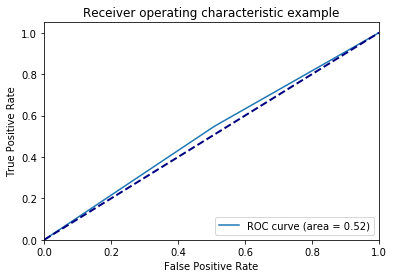

In [184]:
plt.figure()
lw = 2

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Random Froest
#### Tunning Hyperparameters

1. max_features = ['auto','log2','sqrt']
2. min_samples_leaf = [1,5,10,50,100]
3. n_estimators = [300, 500, 1000, 5000]

In [71]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, split in enumerate(['auto','log2','sqrt']):
    clf = RandomForestClassifier(n_estimators=500,max_features=split,random_state=2,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.41726618705
F1 score: 0.398723574308
Predicted  -1   0   1
Actual               
-1          9   9  25
 0          9  17  20
 1          7  11  32
Accuracy score: 0.395683453237
F1 score: 0.377269394953
Predicted  -1   0   1
Actual               
-1          8   9  26
 0          4  17  25
 1          8  12  30
Accuracy score: 0.41726618705
F1 score: 0.398723574308
Predicted  -1   0   1
Actual               
-1          9   9  25
 0          9  17  20
 1          7  11  32
{0: 0.532258064516129, 1: 0.49989357173265214, 2: 0.532258064516129}


In [72]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, leaf_size in enumerate([1,5,10,50,100]):
    clf = RandomForestClassifier(n_estimators=500,max_features='log2',min_samples_leaf=leaf_size,random_state=2,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.395683453237
F1 score: 0.377269394953
Predicted  -1   0   1
Actual               
-1          8   9  26
 0          4  17  25
 1          8  12  30
Accuracy score: 0.323741007194
F1 score: 0.287530382853
Predicted  -1   0   1
Actual               
-1          5  12  26
 0          5   9  32
 1          8  11  31
Accuracy score: 0.41726618705
F1 score: 0.371551514869
Predicted  -1   0   1
Actual               
-1          4  12  27
 0          2  18  26
 1          4  10  36
Accuracy score: 0.36690647482
F1 score: 0.24426173347
Predicted  0   1
Actual          
-1         5  38
 0         5  41
 1         4  46


/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy score: 0.381294964029
F1 score: 0.234151273576
Predicted  0   1
Actual          
-1         1  42
 0         3  43
 1         0  50
{0: 0.49989357173265214, 1: 0.50438202247191011, 2: 0.54831460674157295, 3: 0.54542857142857148, 4: 0.60833333333333339}


/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, n_estimators in enumerate([300, 500, 1000, 5000]):
    clf = RandomForestClassifier(n_estimators,max_features='log2',min_samples_leaf=1,random_state=2,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.323741007194
F1 score: 0.315318756716
Predicted  -1   0   1
Actual               
-1          7   9  27
 0          7  16  23
 1         14  14  22
Accuracy score: 0.395683453237
F1 score: 0.377269394953
Predicted  -1   0   1
Actual               
-1          8   9  26
 0          4  17  25
 1          8  12  30
Accuracy score: 0.330935251799
F1 score: 0.307290376978
Predicted  -1   0   1
Actual               
-1          4  10  29
 0          4  16  26
 1         11  13  26
Accuracy score: 0.374100719424
F1 score: 0.327780961813
Predicted  -1   0   1
Actual               
-1          4  10  29
 0          3  13  30
 1          3  12  35
{0: 0.41759950248756217, 1: 0.49989357173265214, 2: 0.43060876968922945, 3: 0.51430260047281329}


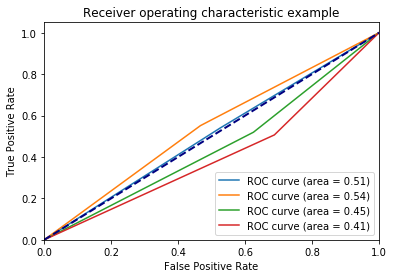

In [51]:
plt.figure()
lw = 2
for i, f in enumerate(fpr):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression
#### Tuning Parameters

1. penalty = ['l1','l2']
2. C = [0.00001,0.001,1.0,10.0,100.0]

In [52]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, p in enumerate(['l1','l2']):
    LR_clf = LogisticRegression(penalty=p,random_state=1)
    LR_clf.fit(X_train, y_train)
    y_predict = LR_clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.47311827957
F1 score: 0.472627300681
Predicted  -1   1
Actual           
-1         18  25
 1         24  26
Accuracy score: 0.440860215054
F1 score: 0.441508568237
Predicted  -1   1
Actual           
-1         18  25
 1         27  23
{0: 0.46918767507002801, 1: 0.43958333333333333}


In [53]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, C in enumerate([0.00001, 0.001, 1.0, 10.0, 100.0]):
    LR_clf = LogisticRegression(penalty='l1',C=C)
    LR_clf.fit(X_train, y_train)
    y_predict = LR_clf.predict(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_predict, y_test, pos_label=1)
    print('Accuracy score:', accuracy_score(y_test, y_predict))
    f_score = f1_score(y_test, y_predict, average='weighted')
    print('F1 score:', f_score)
    crossdf = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    print(crossdf)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print(roc_auc)

Accuracy score: 0.462365591398
F1 score: 0.292378241619
Predicted  -1
Actual       
-1         43
 1         50
Accuracy score: 0.462365591398
F1 score: 0.292378241619
Predicted  -1
Actual       
-1         43
 1         50
Accuracy score: 0.47311827957
F1 score: 0.472627300681
Predicted  -1   1
Actual           
-1         18  25
 1         24  26
Accuracy score: 0.47311827957
F1 score: 0.472627300681
Predicted  -1   1
Actual           
-1         18  25
 1         24  26
Accuracy score: 0.462365591398
F1 score: 0.461236107346
Predicted  -1   1
Actual           
-1         17  26
 1         24  26
{0: nan, 1: nan, 2: 0.46918767507002801, 3: 0.46918767507002801, 4: 0.45731707317073178}


/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:547: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
